In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-sample-3/"
transfer_files = [
    "1-2021-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "2-2021-transfers.parquet",
    "9-2020-transfers.parquet",
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))


asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Mar-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)

In [3]:
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

lookup = asid_lookup[["ASID", "MName"]]
transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

In [15]:
def pivot_by_status(df, index_colum):
    status_counts = transfers.pivot_table(index=index_colum, columns="status", values="conversation_id", aggfunc=len, fill_value=0)
    return (status_counts.div(status_counts.sum(axis=1), axis=0) * 100).round(decimals=2)

In [14]:
def plot_status_breakdown(statuses):
    columns = ["INTEGRATED", "PENDING", "PENDING_WITH_ERROR", "FAILED"]
    colours = ['green', 'orange', 'purple', 'red']
    statuses[columns].plot.barh(stacked=True, figsize=(13, 8), color=colours)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


status,FAILED,INTEGRATED,PENDING,PENDING_WITH_ERROR
requesting_supplier,,,,
EMIS,1.76,94.19,2.73,1.32
Microtest,0.67,8.80,27.25,63.29
TPP,3.17,92.30,3.75,0.78
Unknown,4.01,86.36,4.01,5.63
Vision,1.21,46.09,12.70,40.00


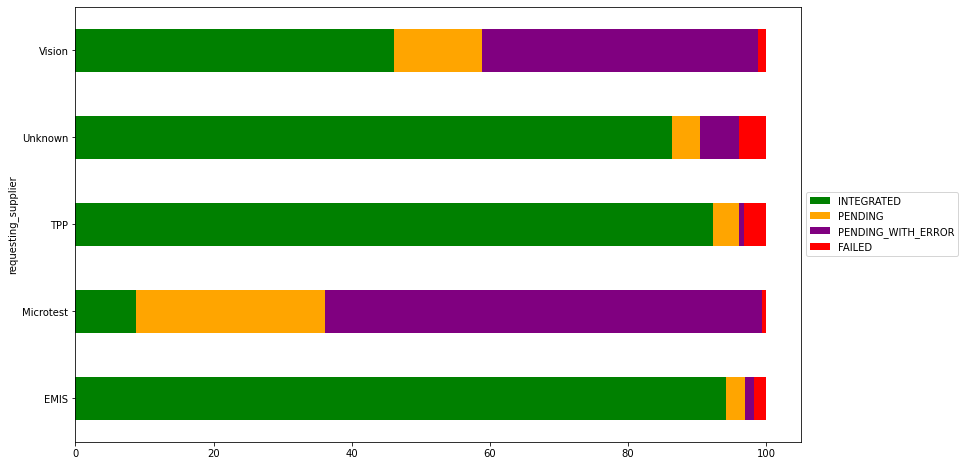

In [18]:
status_by_requester = pivot_by_status(transfers, "requesting_supplier")
plot_status_breakdown(status_by_requester)
status_by_requester

status,FAILED,INTEGRATED,PENDING,PENDING_WITH_ERROR
sending_supplier,,,,
EMIS,1.28,95.33,2.06,1.33
Microtest,0.58,7.29,58.99,33.14
TPP,5.43,87.11,2.66,4.80
Unknown,3.34,82.27,8.52,5.87
Vision,0.78,55.13,43.67,0.42


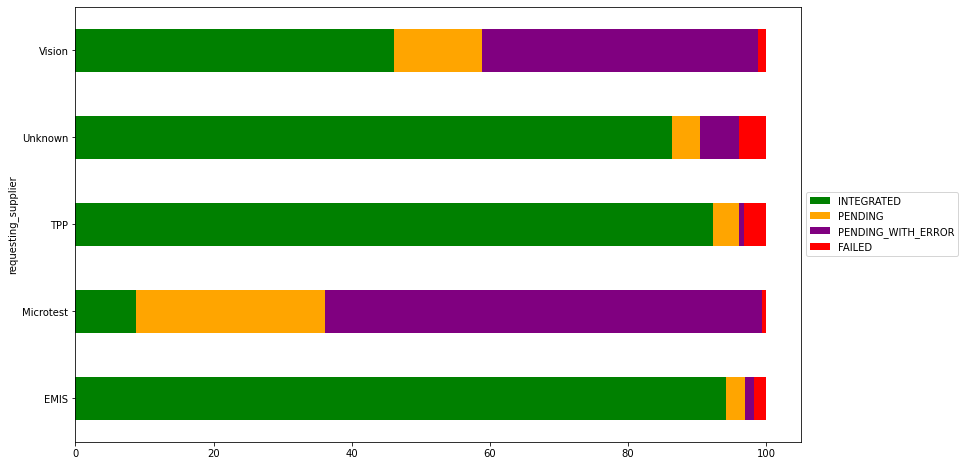

In [19]:
status_by_sender = pivot_by_status(transfers, "sending_supplier")
plot_status_breakdown(status_by_requestor)
status_by_sender

status                                FAILED  INTEGRATED  PENDING  \
requesting_supplier sending_supplier                                
EMIS                EMIS                0.65       96.92     1.72   
                    Microtest           1.18        8.28    63.91   
                    TPP                 5.52       88.60     2.54   
                    Unknown             1.38       82.06    11.48   
                    Vision              0.84       56.28    42.41   
Microtest           EMIS                1.13       15.79    25.56   
                    Microtest           0.00        0.00    78.29   
                    TPP                 0.27        1.92     9.86   
                    Unknown             0.00        0.00     0.00   
                    Vision              0.00        7.69    92.31   
TPP                 EMIS                3.19       93.23     2.92   
                    Microtest           0.00        8.66    46.72   
                    TPP                 0.00        0.00    80.75   
                    Unknown             6.60       83.88     4.06   
                    Vision              1.18       59.86    38.38   
Unknown             EMIS                1.32       95.12     2.00   
                    Microtest           0.00        0.00    22.22   
                    TPP                 7.28       77.62     5.19   
                    Unknown             6.35       77.78     0.00   
                    Vision              0.00       55.56    44.44   
Vision              EMIS                1.75       53.78     4.10   
                    Microtest           0.00        0.00    66.67   
                    TPP                 0.31       15.77     1.41   
                    Unknown             0.00       55.36     5.36   
                    Vision              0.02       44.46    55.47   

status                                PENDING_WITH_ERROR  
requesting_supplier sending_supplier                      
EMIS                EMIS                            0.71  
                    Microtest                      26.63  
                    TPP                             3.33  
                    Unknown                         5.08  
                    Vision                          0.46  
Microtest           EMIS                           57.52  
                    Microtest                      21.71  
                    TPP                            87.95  
                    Unknown                       100.00  
                    Vision                          0.00  
TPP                 EMIS                            0.66  
                    Microtest                      44.62  
                    TPP                            19.25  
                    Unknown                         5.46  
                    Vision                          0.58  
Unknown             EMIS                            1.56  
                    Microtest                      77.78  
                    TPP                             9.91  
                    Unknown                        15.87  
                    Vision                          0.00  
Vision              EMIS                           40.37  
                    Microtest                      33.33  
                    TPP                            82.51  
                    Unknown                        39.29  
                    Vision                          0.05

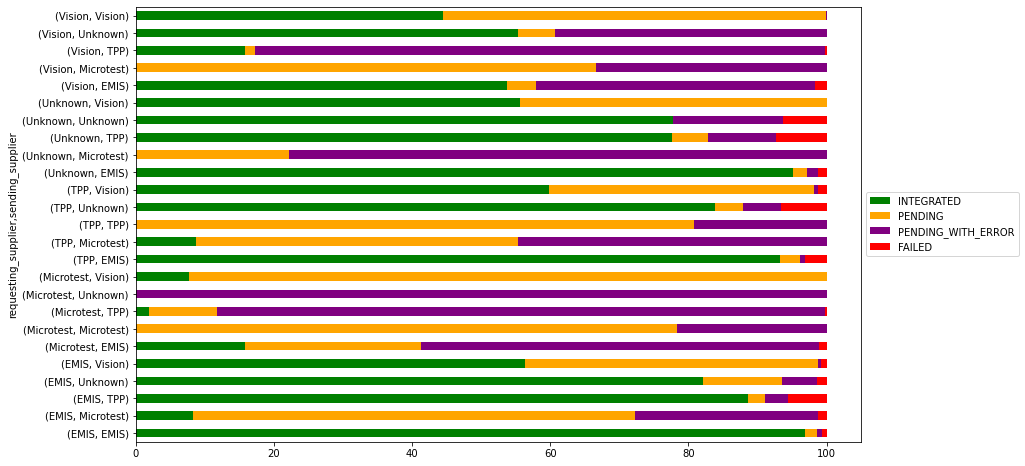

In [20]:
status_by_pathway = pivot_by_status(transfers, ["requesting_supplier", "sending_supplier"])
plot_status_breakdown(status_by_pathway)
status_by_pathway